# Swish-based dense ensemble with categorical entity embedding
- SWish activation, 6 layers, 33 neurons per layer
- PRI_jet_num embedded
- Train-time/test-time data augmentation
- Onecycle
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../../')
from modules.basics import *

In [2]:
NAME = '13_swish_ensemble_embed_aug_onecycle_dense'

In [3]:
experiment = Experiment(NAME, 'morpheus', RESULTS_PATH)

In [4]:
!python ../../modules/data_import.py -d ../../data/ -f PRI_jet_num -s {experiment.seed}

Converting to use_cartesian coordinates
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 31 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_met_pt']
rm: cannot remove ‘../../data/train.hdf5’: No such file or directory
Saving fold 0 with 20003 events
Saving fold 1 with 20003 events
Saving fold 2 with 20003 events
Saving fold 3 with 20003 events
Saving fold 4 with 20002 events
Saving fold 5 with 20001 events
Sa

## Training

### Import data

In [5]:
train_fy = HEPAugFoldYielder(DATA_PATH/'train.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [6]:
train_feats = train_fy.cont_feats+train_fy.cat_feats

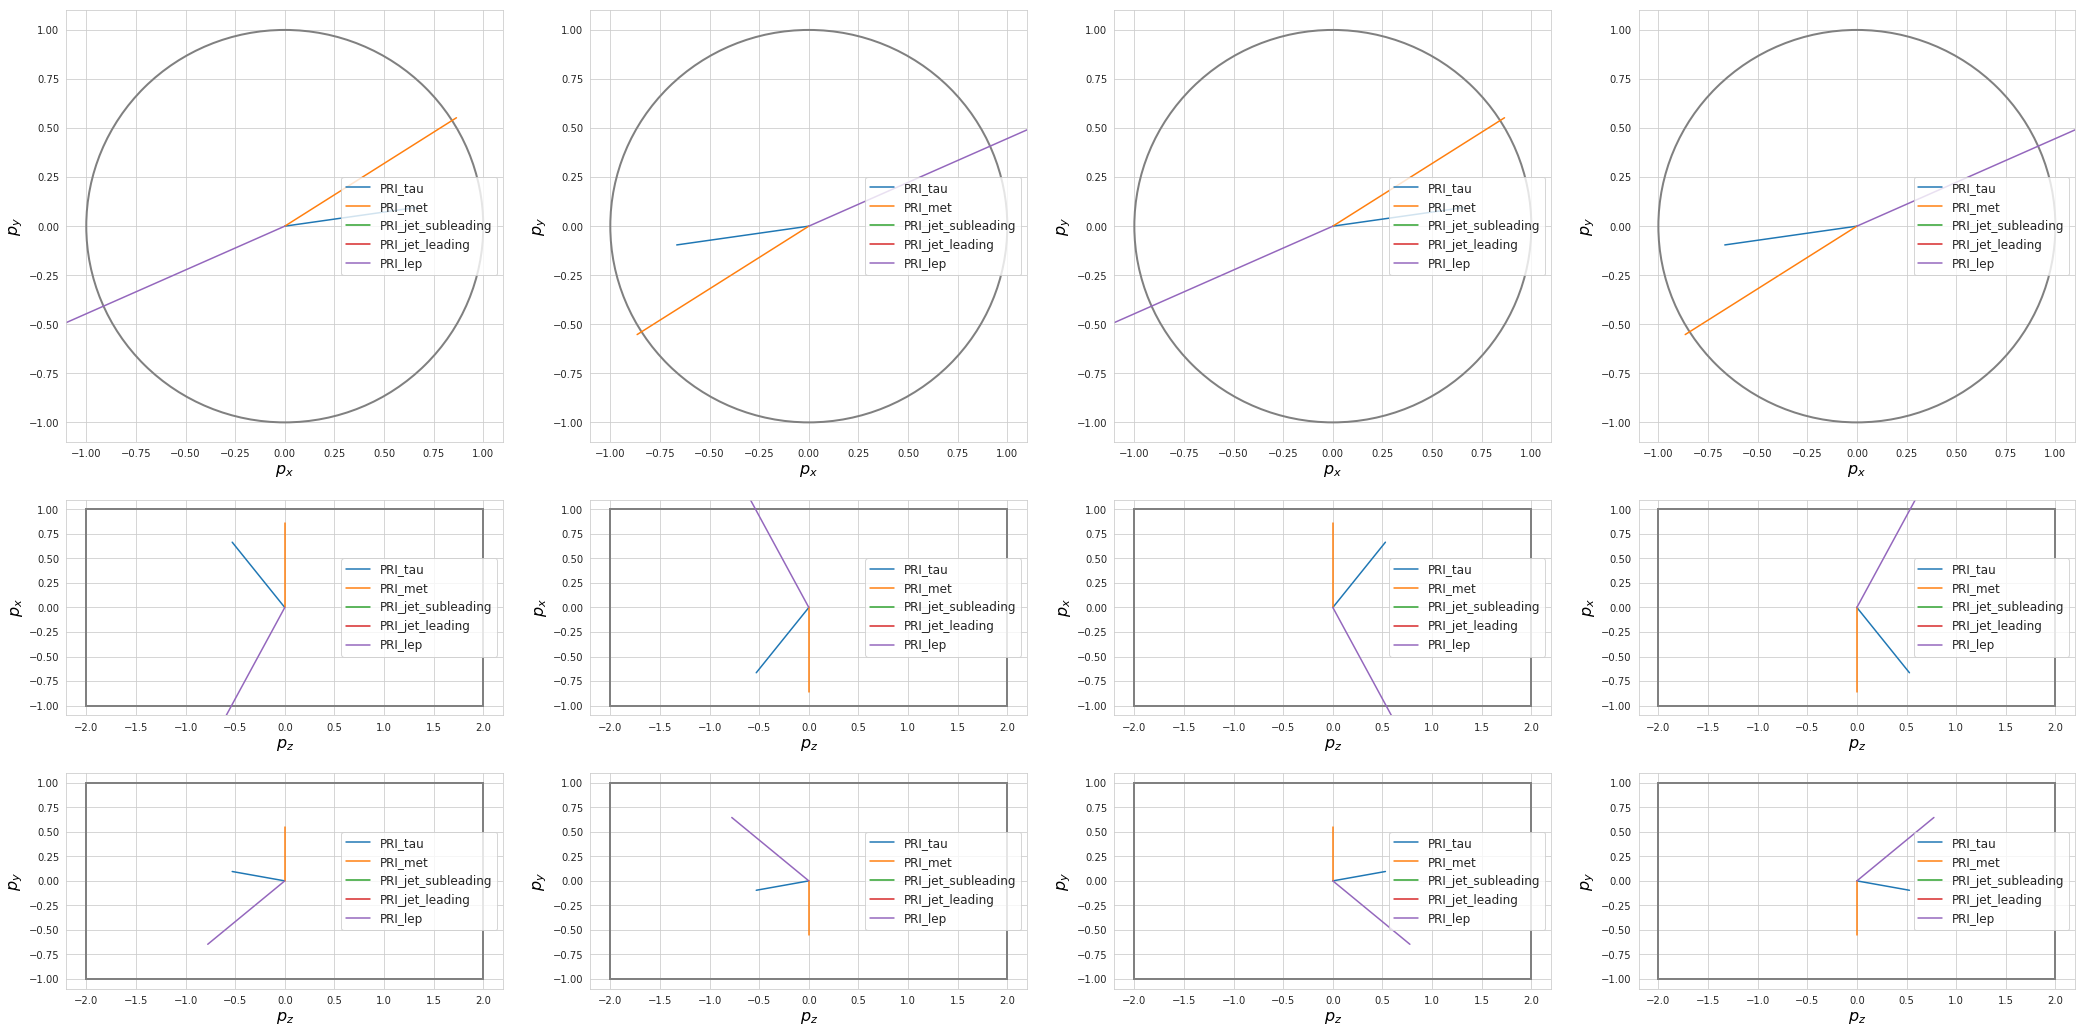

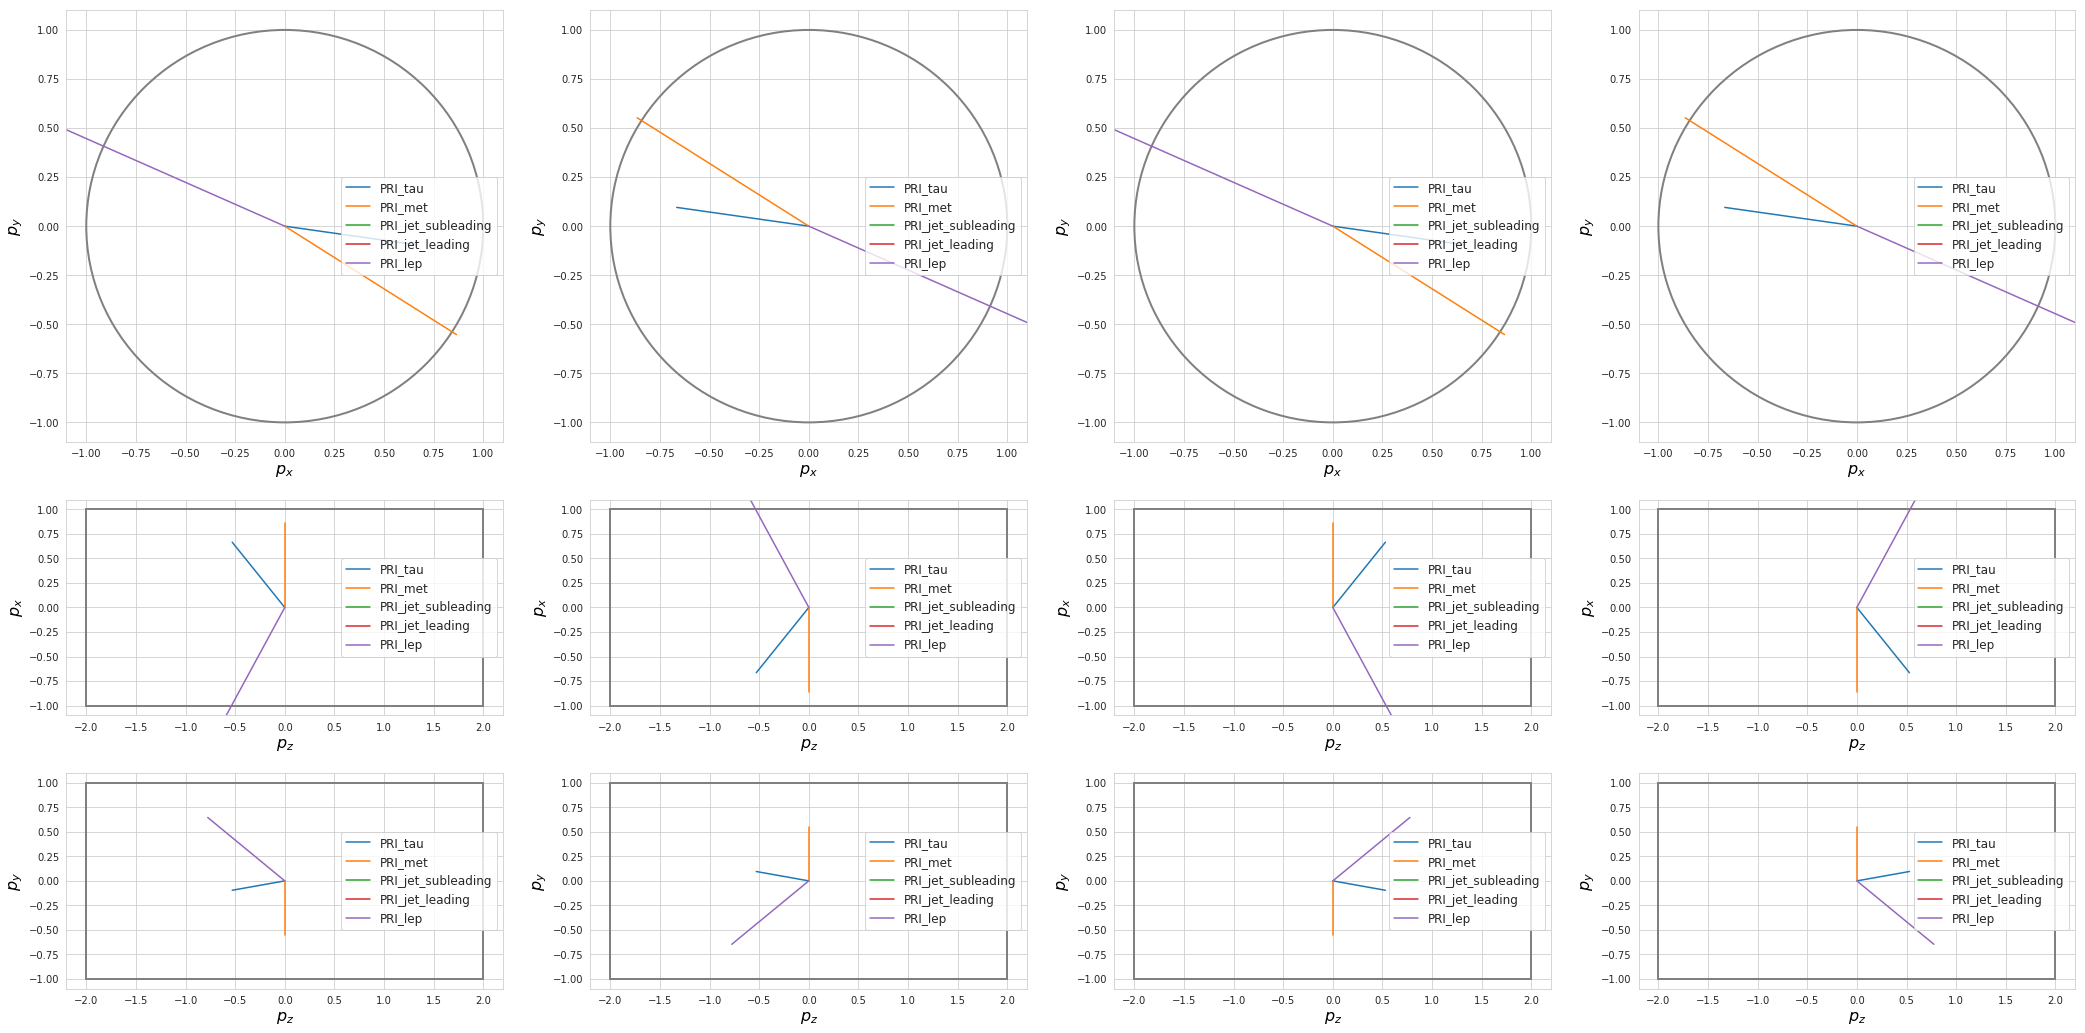

In [7]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    compare_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

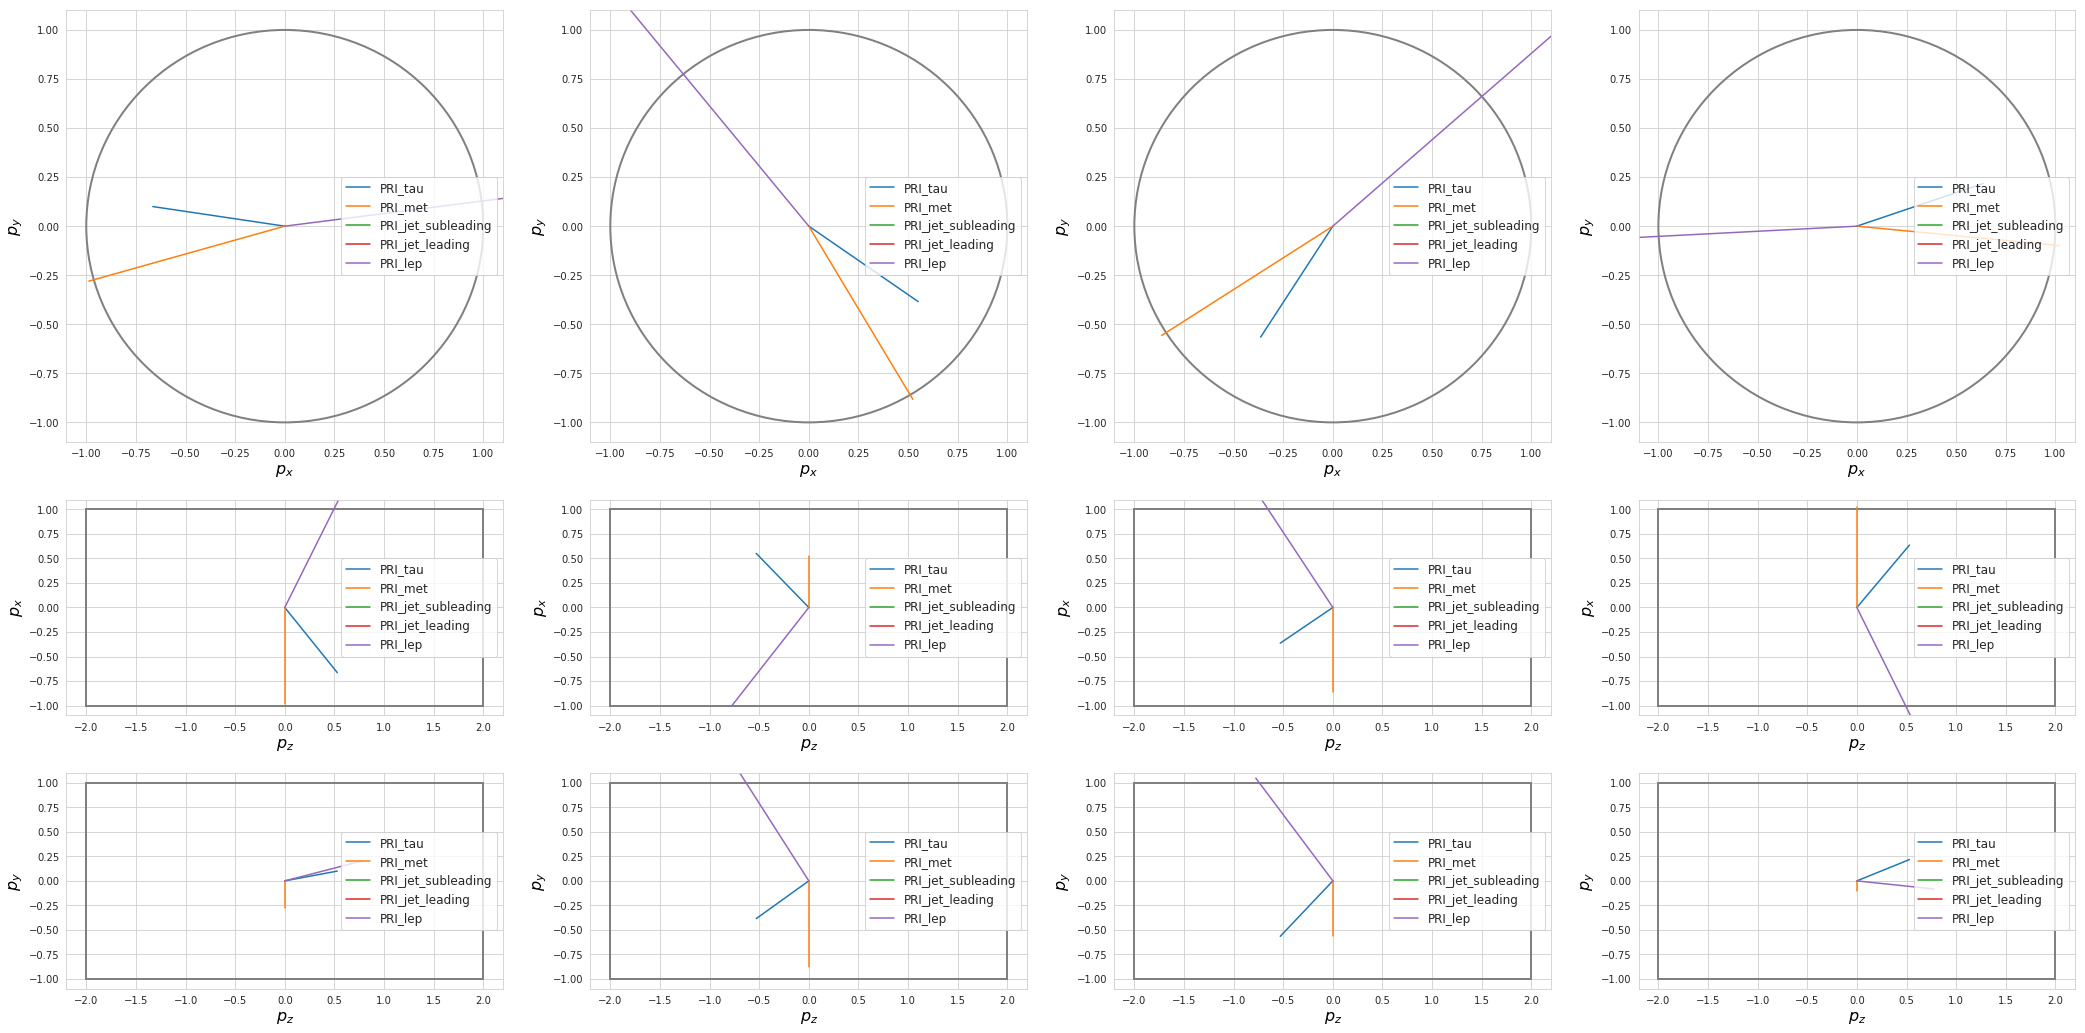

In [8]:
id=3
compare_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1] for i in range(4)])

### Options

In [9]:
n_models = 10
patience = 50
max_epochs = 15
ensemble_size = 10

bs = 256
objective = 'classification'
model_args = {'body':{'act':'swish', 'width':33, 'depth':6, 'dense':True}}
opt_args = {'opt':'adam', 'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_fy, emb_szs=[3])

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)
Model(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 3)
    )
  )
  (1): FullyConnected(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=33, out_features=33, bias=True)
        (1): Swish

### Determine LR

LR finder took 8.475s 


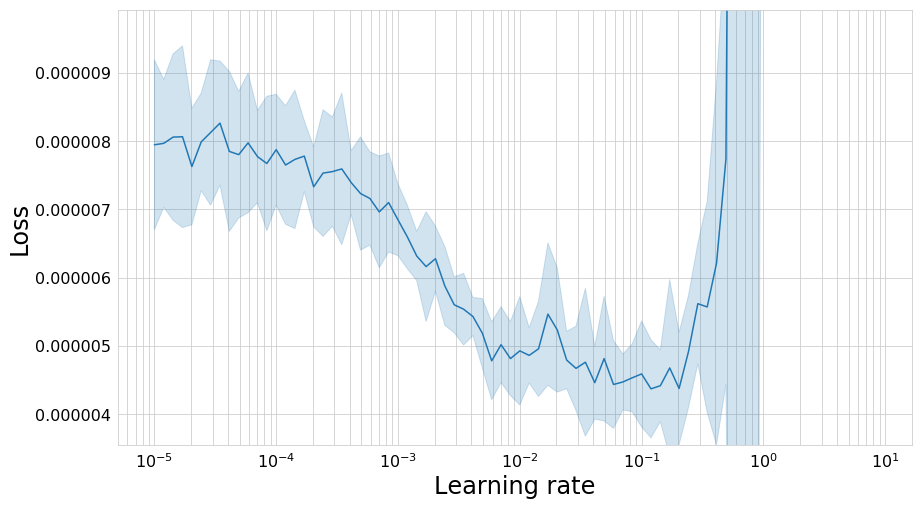

In [10]:
lr_finder = fold_lr_find(train_fy, model_builder, 256, lr_bounds=[1e-5,1e1])

### Train classifier

In [11]:
callback_partials = [partial(OneCycle, lengths=(45, 90), lr_range=[1e-4, 1e-2], mom_range=(0.85, 0.95), interp='cosine')]
eval_metrics = {'AMS':AMS(n_total=250000, br=10, wgt_name='gen_weight_original')}

Training model 1 / 10, Val ID = 0


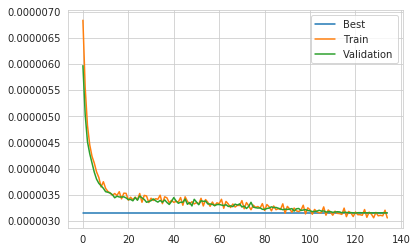

Early stopping after 135 epochs
Scores are: {'loss': 3.1507795483776135e-06, 'AMS': 3.8567194709641113}
Fold took 138.770s

Training model 2 / 10, Val ID = 1


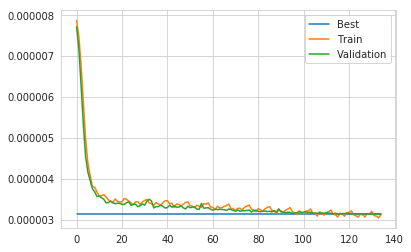

Early stopping after 135 epochs
Scores are: {'loss': 3.145761183986906e-06, 'AMS': 4.02193701923069}
Fold took 141.248s

Training model 3 / 10, Val ID = 2


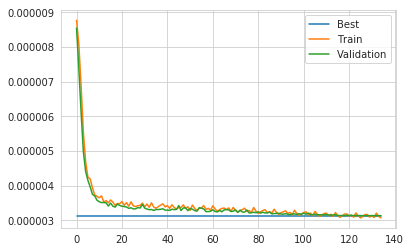

Early stopping after 135 epochs
Scores are: {'loss': 3.131428684355342e-06, 'AMS': 3.9440783314690666}
Fold took 138.020s

Training model 4 / 10, Val ID = 3


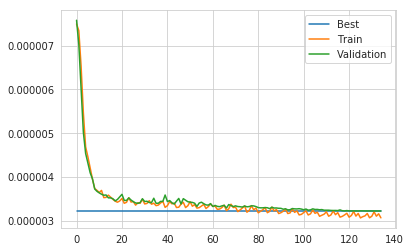

Early stopping after 135 epochs
Scores are: {'loss': 3.2253631161438534e-06, 'AMS': 4.138413796411024}
Fold took 139.694s

Training model 5 / 10, Val ID = 4


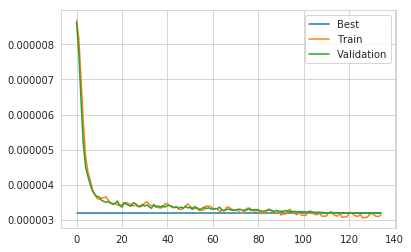

Early stopping after 135 epochs
Scores are: {'loss': 3.191928271917277e-06, 'AMS': 3.4988946595298587}
Fold took 139.618s

Training model 6 / 10, Val ID = 5


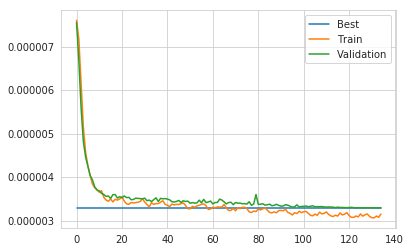

Early stopping after 135 epochs
Scores are: {'loss': 3.2935201943473658e-06, 'AMS': 4.131406229612918}
Fold took 140.629s

Training model 7 / 10, Val ID = 6


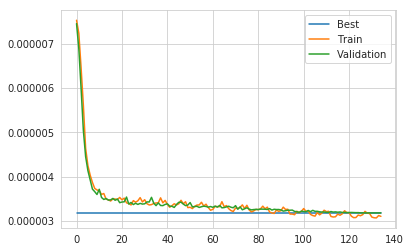

Early stopping after 135 epochs
Scores are: {'loss': 3.1785732517164433e-06, 'AMS': 3.650715130367218}
Fold took 138.707s

Training model 8 / 10, Val ID = 7


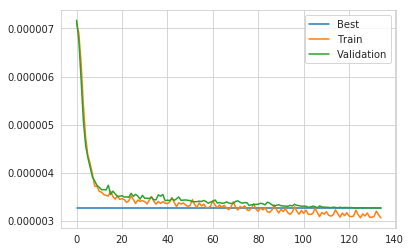

Early stopping after 135 epochs
Scores are: {'loss': 3.2653722428221954e-06, 'AMS': 3.9063839463609877}
Fold took 140.116s

Training model 9 / 10, Val ID = 8


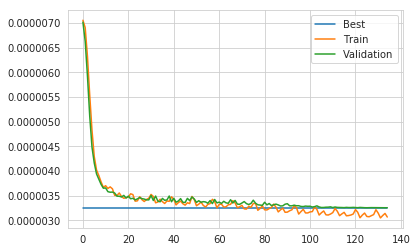

Early stopping after 135 epochs
Scores are: {'loss': 3.253213662901544e-06, 'AMS': 4.257468139958479}
Fold took 141.538s

Training model 10 / 10, Val ID = 9


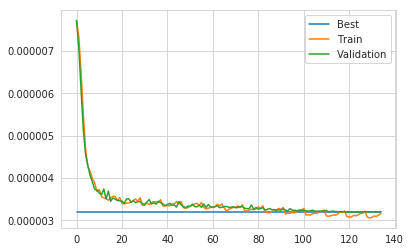

Early stopping after 135 epochs
Scores are: {'loss': 3.191481482645031e-06, 'AMS': 4.167135307211358}
Fold took 138.082s


______________________________________
Training finished
Cross-validation took 1396.429s 


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

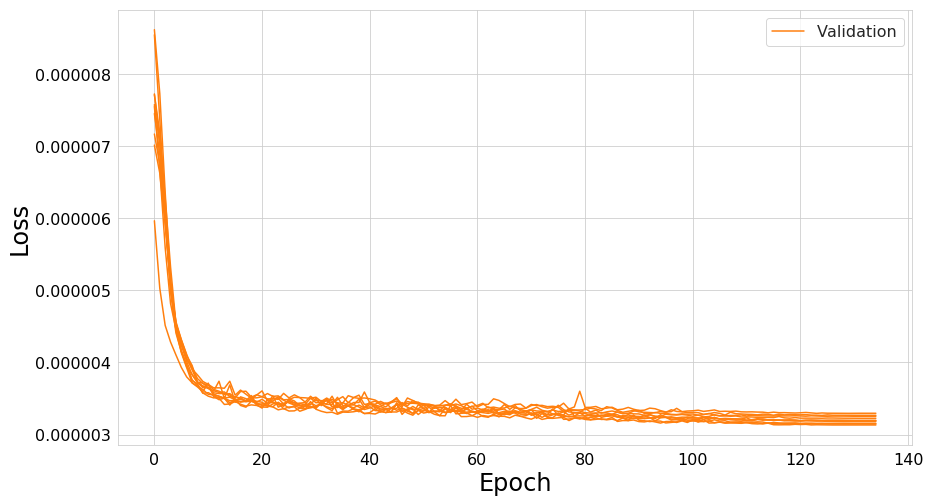

Mean loss = 3.2e-06±2e-08
Mean AMS = 3.96±0.07
______________________________________



In [12]:
train_timer = timeit.default_timer()
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience)
train_time = timeit.default_timer()-train_timer
experiment['train_time'] = train_time

## Inference

### Construct ensemble

In [13]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [14]:
ensemble = Ensemble.from_results(results, ensemble_size, model_builder, metric='loss', higher_metric_better=False)

Choosing ensemble by loss


Model 0 is 2 with loss = 3.131428684355342e-06
Model 1 is 1 with loss = 3.145761183986906e-06
Model 2 is 0 with loss = 3.1507795483776135e-06
Model 3 is 6 with loss = 3.1785732517164433e-06
Model 4 is 9 with loss = 3.191481482645031e-06
Model 5 is 4 with loss = 3.191928271917277e-06
Model 6 is 3 with loss = 3.2253631161438534e-06
Model 7 is 8 with loss = 3.253213662901544e-06
Model 8 is 7 with loss = 3.2653722428221954e-06
Model 9 is 5 with loss = 3.2935201943473658e-06


### Validation

#### Response on validation data without TTA

In [15]:
val_fy = FoldYielder(DATA_PATH/'val.hdf5')

In [16]:
val_timer = timeit.default_timer()
ensemble.predict(val_fy)
val_time = timeit.default_timer()-val_timer
experiment['val_time_no_tta'] = val_time

Mean time per event = 2.83e-05±6e-07


In [17]:
val_df = val_fy.get_df()

50000 datapoints loaded


Mean cut at 0.9560158252716064 corresponds to AMS of 3.994478430835254
Maximum AMS for data is 4.1302076811052695 at cut of 0.9732221364974976


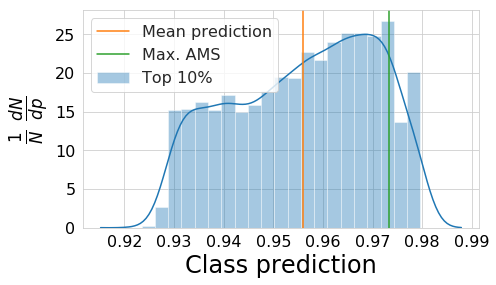

In [18]:
cut, experiment['val_ams_smooth_no_tta'], experiment['val_ams_max_no_tta'] = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

#### Response on validation data with TTA

In [20]:
val_fy = HEPAugFoldYielder(DATA_PATH/'val.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [21]:
val_timer = timeit.default_timer()
ensemble.predict(val_fy, pred_name='pred_tta')
val_time = timeit.default_timer()-val_timer
experiment['val_time'] = val_time

Mean time per event = 0.000342±2e-06


In [22]:
val_df = val_fy.get_df(pred_name='pred_tta')

50000 datapoints loaded


Mean cut at 0.9539031386375427 corresponds to AMS of 4.005874674970222
Maximum AMS for data is 4.135994188780372 at cut of 0.972503125667572


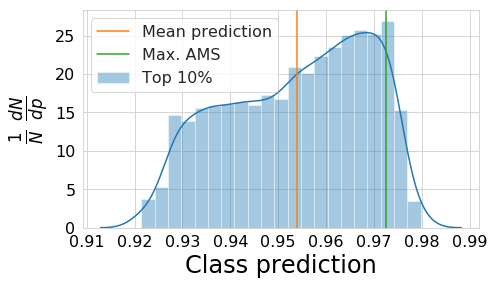

In [23]:
cut_tta, experiment['val_ams_smooth'], experiment['val_ams_max'] = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

### Testing

#### Test scoring without TTA

In [24]:
test_fy = FoldYielder(DATA_PATH/'test.hdf5')

In [25]:
test_timer = timeit.default_timer()
ensemble.predict(test_fy)
test_time = timeit.default_timer()-test_timer
experiment['test_time_no_tta'] = test_time

Mean time per event = 3.53e-05±5e-07


In [26]:
experiment['test_public_ams_mean_no_tta'], experiment['test_private_ams_mean_no_tta'] = score_test_data_per_fold(test_fy, cut, pred_name='pred')

Mean Public:Private AMS: 3.8±0.1 : 3.81±0.05


In [27]:
experiment['test_public_ams_no_tta'], experiment['test_private_ams_no_tta'] = score_test_data(test_fy, cut, pred_name='pred')

Public:Private AMS: 3.74820579555785 : 3.8016500885916815


#### Test scoring with TTA

In [28]:
test_fy = HEPAugFoldYielder(DATA_PATH/'test.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [29]:
test_timer = timeit.default_timer()
ensemble.predict(test_fy, pred_name='pred_tta')
test_time = timeit.default_timer()-test_timer
experiment['test_time'] = test_time

Mean time per event = 0.000307±4e-06


In [30]:
experiment['test_public_ams_mean'], experiment['test_private_ams_mean'] = score_test_data_per_fold(test_fy, cut_tta, pred_name='pred_tta')

Mean Public:Private AMS: 3.79±0.1 : 3.82±0.05


In [31]:
experiment['test_public_ams'], experiment['test_private_ams'] = score_test_data(test_fy, cut_tta, pred_name='pred_tta')

Public:Private AMS: 3.768373972171409 : 3.8112865970792797


## Results 

In [32]:
experiment

Experiment:	13_swish_ensemble_embed_aug_onecycle_dense
Machine:	morpheus
Device:	Intel Xenon Skylake CPU @ 2.2 GHz (2x2)
train_time	1397.3590333350003
val_time_no_tta	1.42796029150486
val_ams_smooth_no_tta	3.994478430835254
val_ams_max_no_tta	4.1302076811052695
val_time	17.115993600338697
val_ams_smooth	4.005874674970222
val_ams_max	4.135994188780372
test_time_no_tta	19.45932426303625
test_public_ams_mean_no_tta	(3.7709854231229345, 0.10524435586849078)
test_private_ams_mean_no_tta	(3.8105927978052136, 0.054866488912377394)
test_public_ams_no_tta	3.74820579555785
test_private_ams_no_tta	3.8016500885916815
test_time	168.9303200505674
test_public_ams_mean	(3.7906482005553066, 0.09732829956795211)
test_private_ams_mean	(3.8199120271128164, 0.05443952141918933)
test_public_ams	3.768373972171409
test_private_ams	3.8112865970792797

In [33]:
experiment.save()